In [1]:
#pip install wandb --upgrade

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.15
    Uninstalling wandb-0.12.15:
      Successfully uninstalled wandb-0.12.15
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline

import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
import math

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet121
from itertools import cycle
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm

## Setting

In [2]:
#from PIL import Image
from tf_keras_vis.utils import num_of_gpus

# !pip install keras-vis
# !pip install tf-keras-vis

%reload_ext autoreload
%autoreload 2
%matplotlib inline

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


In [3]:
#from tf_keras_vis.utils import num_of_gpus
import collections
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
#from sklearn.model_selection import train_test_split
import matplotlib as mpl
#import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv1D,Conv2D, Flatten
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Check path
my_path = os.getcwd()
my_dir = '/home/ubuntu/Kyulee/ECG_2210/'
train_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/221028_STEMI/'
My_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/2023_Jan_testset/'
print('work_path: {}\ndata_directory: {}'.format(my_path, my_dir))

work_path: /home/ubuntu/Kyulee/ECG_2301
data_directory: /home/ubuntu/Kyulee/ECG_2210/


# 1. Data Load

In [11]:
# load dataset
X_train, Y_train = np.load(train_dir+'x_train_1114.npy'), np.load(train_dir+'y_train_1114.npy')
X_test, Y_test = np.load(My_dir+'x_test_0114.npy'), np.load(My_dir+'y_test_0114.npy')

print('X_test {}, Y_test {}'.format(X_test.shape, Y_test.shape))
print('X_train {}, Y_train {}'.format(X_train.shape, Y_train.shape))

X_test (1318, 5000, 8), Y_test (1318,)
X_train (17379, 5000, 8), Y_train (17379,)


In [12]:
# Split train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print('X_train {}, Y_train {}\nX_val {}, Y_val {}'.format(X_train.shape , Y_train.shape, X_val.shape, Y_val.shape))

X_train (15641, 5000, 8), Y_train (15641,)
X_val (1738, 5000, 8), Y_val (1738,)


In [13]:
# Check dataset proportion
counter_train = collections.Counter(Y_train)
counter_val = collections.Counter(Y_val)
counter_test = collections.Counter(Y_test)

def proportion(counters):
    for i, counter in enumerate(counters):
        name = ['Train', 'Validation', 'Test'][i]
        neg, pos = counter[0], counter[1]
        total = neg + pos
        print('{} Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
            name, total, pos, 100 * pos / total, neg, 100 * neg / total))
proportion([counter_train, counter_val, counter_test])

Train Examples:
    Total: 15641
    Positive: 1459 (9.33% of total)
    Negative: 14182 (90.67% of total)

Validation Examples:
    Total: 1738
    Positive: 157 (9.03% of total)
    Negative: 1581 (90.97% of total)

Test Examples:
    Total: 1318
    Positive: 129 (9.79% of total)
    Negative: 1189 (90.21% of total)



In [14]:
# Transform dataset to categorical (one-hot encoding)
y_val =  tf.keras.utils.to_categorical(Y_val)
y_test = tf.keras.utils.to_categorical(Y_test)
print('y_val {}\ny_test {}'.format(y_val.shape, y_test.shape))

y_val (1738, 2)
y_test (1318, 2)


# 2. Modeling

In [15]:
# Load saved model
sing_model = keras.models.load_model(my_dir+'ami_model/0_model-best.h5')

In [16]:
# Load saved model
nets = 5
de_model = [0]*5
for i in [0,1,2,3,4]:
    de_model[i] = keras.models.load_model(my_dir+'ami_model/BestModelSaved/221204_1643'+str(i+1)+'_bestmodel.h5')

# 3. Test

## 3.0. Validation

### 3.0.1. Methods

In [17]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score

In [162]:
# confusion matrix
def matrix(y_true, y_pred, y_proba):
    conf_mat = confusion_matrix(y_true[:,1], y_pred[:,1])
    TP = conf_mat[1][1]
    TN = conf_mat[0][0]
    FN = conf_mat[1][0]
    FP = conf_mat[0][1]

    acc = round((TP+TN)/(TP+TN+FP+FN), 4)
    sens = round(TP/(TP+FN), 4)
    spec = round(TN/(TN+FP), 4)
    ppv = round(TP/ (TP+FP), 4)
    npv = round(TN/ (TN+FN), 4)
    auroc = round(roc_auc_score(y_true, y_proba), 4)
    precision = round(precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    recall = round(recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    f1score = round(f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    ap = round(average_precision_score(y_true, y_pred), 4)

    print(conf_mat, "\n")
    print("Accuracy", acc)
    print("Sensitivity", sens)
    print("Specificity", spec)
    print("PPV", ppv)
    print("NPV", npv)
    print("AUROC", auroc)
    print("Average Precision", ap)
    print('Precision', precision)
    print("Recall", recall)
    print("F1",  f1score)
    
    # ROC & AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red'])
    for i, color in zip(range(y_true.shape[1]), colors):
        if i == 0:
            pass
        else:
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve (area = {0:0.2f})' ''.format(roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted', label = 'baseline')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

label = {'0': 'Not-STEMI', '1':'STEMI'}

In [19]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

def prc(y_true, y_pred, y_proba):
    # PR & AUC
    prec = dict()
    rec = dict()
    pr_auc = dict()
    for i in range(y_true.shape[1]):
        prec[i], rec[i], _ = sklearn.metrics.precision_recall_curve(y_true[:,i], y_proba[:, i])
        pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec[i], recall=rec[i])
    pr_display.plot(label = 'Precision-Recall curve (area = {0:0.2f})' ''.format(average_precision_score(y_true, y_pred)))
    plt.show()

label = {'0': 'Non-STEMI', '1':'STEMI'}

In [164]:
def plot_cm(labels, predictions, p):
    cf_matrix = confusion_matrix(labels, predictions > p)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages_pos = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[0:2]/np.sum(cf_matrix.flatten()[0:2])]
    group_percentages_neg = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[2:4]/np.sum(cf_matrix.flatten()[2:4])]
    group_percentages = group_percentages_pos + group_percentages_neg
    categories = ['Not-STEMI', 'STEMI']
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories, annot_kws={"size": 12})
    plt.title('Confusion Matrix (cut off = {:.2f})'.format(p), fontsize= 14)
    plt.ylabel('Actual label', fontsize= 12)
    plt.xlabel('Predicted label', fontsize= 12)

In [30]:
def result_report(y_test, y_pred, y_proba, threshold):
    print(matrix(y_test, y_pred, y_proba))
    print(prc(y_test, y_pred, y_proba))
    print(plot_cm(y_test[:,1], y_pred[:,1], threshold))

In [78]:
import sklearn
from sklearn.calibration import calibration_curve
def calibration_plot(true, probs, n_bins):
    # reliability diagram
    prob_true, prob_pred = calibration_curve(true[:,1], probs[:,1], n_bins=n_bins)

    # plot perfectly calibrated
    plt.plot([0,1], [0,1], linestyle='--')

    # plot model reliability
    plt.plot(prob_pred, prob_true, marker='.')
    plt.title('Calibration Plot (bins: {0:d})' ''.format(n_bins))
    plt.show()

### 1) Youden's J statistics

In [37]:
#from sklearn.metrics import roc_curve
#from numpy import argmax
def youden(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true[:,1], y_proba[:, 1])
    j_stats = tpr - fpr
    opt_thresholds = thresholds[np.argmax(j_stats)]
    return opt_thresholds

#### (1) single model

In [21]:
sval_proba = sing_model.predict(X_val)

In [38]:
sval_yi = round(youden(y_val, sval_proba),4)
print(' single model: {}'.format(sval_yi))

 single model: 0.014299999922513962


In [ ]:
# 0.5
val_pred = (sval_proba > 0.5).astype(np.int64)

# J statistic
sval_pred = (sval_proba > sval_yi).astype(np.int64)

print(matrix(y_val, val_pred, sval_proba))
print(matrix(y_val, sval_pred, sval_proba))

#### (2) deep ensemble

In [22]:
def test_demodel(de_model, x_dataset):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    #de_pred = (de_proba > cut_off).astype(np.int64) # add cut-off to input
    return de_proba

dval_proba = test_demodel(de_model, X_val)

In [34]:
dval_yi = round(youden(y_val, dval_proba),4)
print(' deep ensemble: {}'.format(dval_yi))

 deep ensemble: 0.0768


In [ ]:
# 0.5
val_pred = (dval_proba > 0.5).astype(np.int64)

# J statistic
dval_pred = (dval_proba > dval_yi).astype(np.int64)

print(matrix(y_val, val_pred, dval_proba))
print(matrix(y_val, dval_pred, dval_proba))

### 2) F-Measure

In [49]:
from sklearn.metrics import precision_recall_curve
def f_score(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true[:,1], y_proba[:, 1])
    fscore = (2 * precision * recall) / (precision + recall)
    opt_thresholds = thresholds[np.argmax(fscore)]
    return opt_thresholds

#### (1) Single Model

In [50]:
sval_f = round(f_score(y_val, sval_proba),4)
print(' single model: {}'.format(sval_f))

 single model: 0.6632000207901001


[[1548   33]
 [  29  128]] 

Accuracy 0.9643
Sensitivity 0.8153
Specificity 0.9791
AUROC 0.9704
Precision 0.795
Recall 0.8153
F1 0.805
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.80      0.82      0.81       157

   micro avg       0.96      0.96      0.96      1738
   macro avg       0.89      0.90      0.89      1738
weighted avg       0.96      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



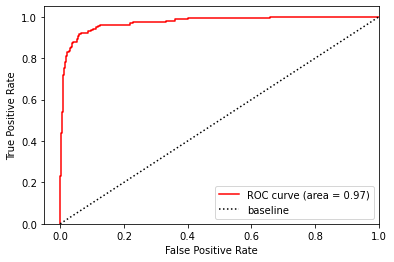

None
[[1552   29]
 [  31  126]] 

Accuracy 0.9655
Sensitivity 0.8025
Specificity 0.9817
AUROC 0.9704
Precision 0.8129
Recall 0.8025
F1 0.8077
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1581
           1       0.81      0.80      0.81       157

   micro avg       0.97      0.96      0.96      1738
   macro avg       0.90      0.89      0.89      1738
weighted avg       0.97      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


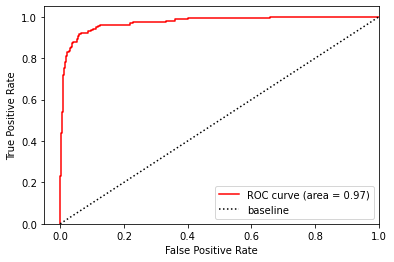

None


In [51]:
# 0.5
val_pred = (sval_proba > 0.5).astype(np.int64)

# F-score
sval_pred = (sval_proba > sval_f).astype(np.int64)

print(matrix(y_val, val_pred, sval_proba))
print(matrix(y_val, sval_pred, sval_proba))

#### (2) Deep Ensemble

In [52]:
dval_f = round(f_score(y_val, dval_proba),4)
print(' deep ensemble: {}'.format(dval_f))

 deep ensemble: 0.6321


[[1551   30]
 [  33  124]] 

Accuracy 0.9638
Sensitivity 0.7898
Specificity 0.981
AUROC 0.9795
Precision 0.8052
Recall 0.7898
F1 0.7974
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.81      0.79      0.80       157

   micro avg       0.96      0.96      0.96      1738
   macro avg       0.89      0.89      0.89      1738
weighted avg       0.96      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



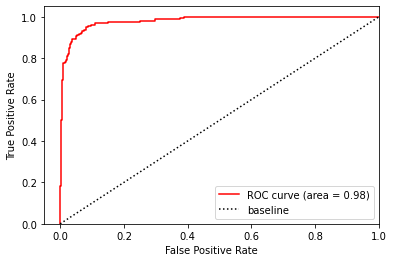

None
[[1568   13]
 [  38  119]] 

Accuracy 0.9707
Sensitivity 0.758
Specificity 0.9918
AUROC 0.9795
Precision 0.9015
Recall 0.758
F1 0.8235
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.90      0.76      0.82       157

   micro avg       0.98      0.96      0.97      1738
   macro avg       0.94      0.87      0.90      1738
weighted avg       0.97      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


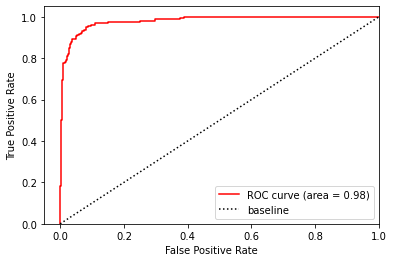

None


In [53]:
# 0.5
val_pred = (dval_proba > 0.5).astype(np.int64)

# f-score
dval_pred = (dval_proba > dval_f).astype(np.int64)

print(matrix(y_val, val_pred, dval_proba))
print(matrix(y_val, dval_pred, dval_proba))

### 3) Average Precision

In [60]:
from numpy import arange
def AP(y_true, y_proba):
    thresholds = arange(0, 1, 0.001)
    scores = [average_precision_score(y_true, to_labels(y_proba, t)) for t in thresholds]
    idx = np.argmax(scores)
    opt_thresholds = thresholds[idx]
    #print('Threshold=%.4f, AP=%.5f' % (thresholds[ix], scores[ix]))
    return opt_thresholds

def to_labels(pos_probs, threshold):
    return(pos_probs >= threshold).astype('int')

In [62]:
sval_ap = round(AP(y_val, sval_proba),4)
print(' single model: {}'.format(sval_ap))

 single model: 0.806


In [61]:
dval_ap = round(AP(y_val, dval_proba),4)
print(' deep ensemble: {}'.format(dval_ap))

 deep ensemble: 0.631


#### (1) Single Model

[[1548   33]
 [  29  128]] 

Accuracy 0.9643
Sensitivity 0.8153
Specificity 0.9791
AUROC 0.9704
Precision 0.795
Recall 0.8153
F1 0.805
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.80      0.82      0.81       157

   micro avg       0.96      0.96      0.96      1738
   macro avg       0.89      0.90      0.89      1738
weighted avg       0.96      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



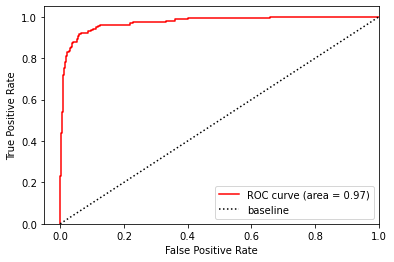

None
[[1556   25]
 [  34  123]] 

Accuracy 0.9661
Sensitivity 0.7834
Specificity 0.9842
AUROC 0.9704
Precision 0.8311
Recall 0.7834
F1 0.8066
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1581
           1       0.83      0.78      0.81       157

   micro avg       0.97      0.95      0.96      1738
   macro avg       0.91      0.88      0.89      1738
weighted avg       0.97      0.95      0.96      1738
 samples avg       0.95      0.95      0.95      1738



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


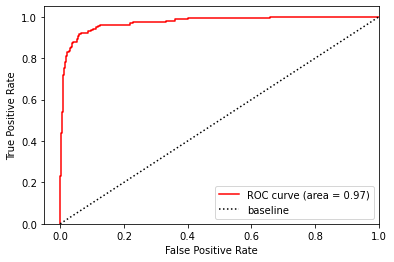

None


In [63]:
# 0.5
val_pred = (sval_proba > 0.5).astype(np.int64)

# average precision
sval_pred = (sval_proba > sval_ap).astype(np.int64)

print(matrix(y_val, val_pred, sval_proba))
print(matrix(y_val, sval_pred, sval_proba))

#### (2) Deep Ensemble

[[1551   30]
 [  33  124]] 

Accuracy 0.9638
Sensitivity 0.7898
Specificity 0.981
AUROC 0.9795
Precision 0.8052
Recall 0.7898
F1 0.7974
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.81      0.79      0.80       157

   micro avg       0.96      0.96      0.96      1738
   macro avg       0.89      0.89      0.89      1738
weighted avg       0.96      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



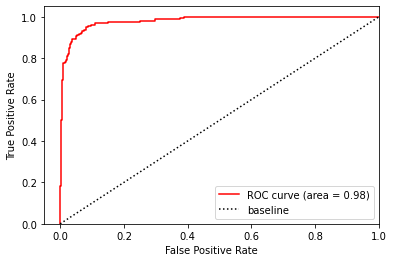

None
[[1568   13]
 [  37  120]] 

Accuracy 0.9712
Sensitivity 0.7643
Specificity 0.9918
AUROC 0.9795
Precision 0.9023
Recall 0.7643
F1 0.8276
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1581
           1       0.90      0.76      0.83       157

   micro avg       0.98      0.96      0.97      1738
   macro avg       0.94      0.87      0.90      1738
weighted avg       0.97      0.96      0.96      1738
 samples avg       0.96      0.96      0.96      1738



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


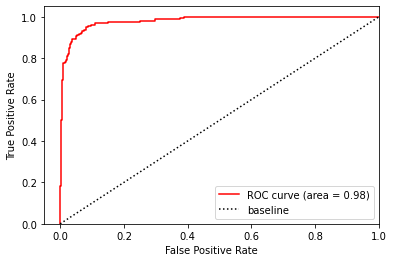

None


In [64]:
# 0.5
val_pred = (dval_proba > 0.5).astype(np.int64)

# average precision
dval_pred = (dval_proba > dval_ap).astype(np.int64)

print(matrix(y_val, val_pred, dval_proba))
print(matrix(y_val, dval_pred, dval_proba))

## 4.1. Single Model

In [16]:
loss = sing_model.evaluate(X_test, y_test)
print(loss)

42/42 [==============================] - 1s 11ms/step - loss: 0.1020 - accuracy: 0.9644 - prc: 0.9835
[0.10199300944805145, 0.9643669724464417, 0.9834597110748291]


In [68]:
sing_proba = sing_model.predict(X_test)

[[1113   76]
 [   7  122]] 

Accuracy 0.937
Sensitivity 0.9457
Specificity 0.9361
PPV 0.6162
NPV 0.9938
AUROC 0.9805
Average Precision 0.7801
Precision 0.9057
Recall 0.7442
F1 0.817
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1189
           1       0.62      0.95      0.75       129

   micro avg       0.92      0.99      0.95      1318
   macro avg       0.79      0.97      0.86      1318
weighted avg       0.94      0.99      0.96      1318
 samples avg       0.95      0.99      0.96      1318



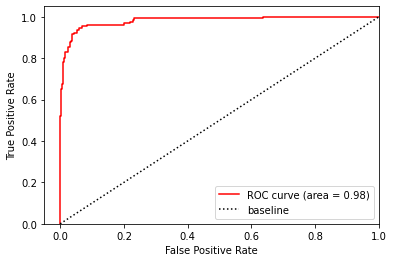

None


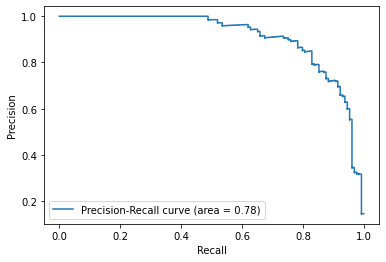

None
True Negatives:  1113
False Positives:  76
False Negatives:  7
True Positives:  122
Total STEMI:  129
None


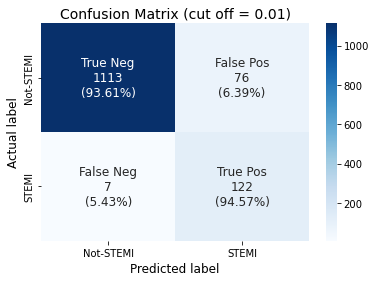

In [74]:
sing_pred = (sing_proba > sval_yi).astype(np.int64)
result_report(y_test, sing_pred, sing_proba, sval_yi)

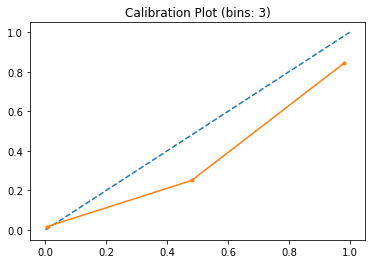

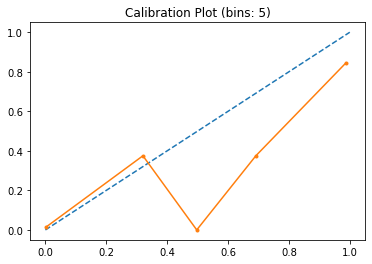

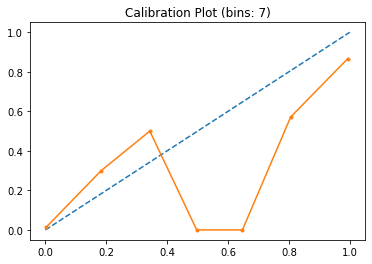

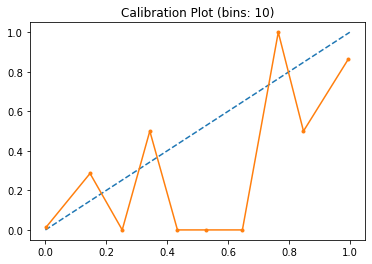

In [79]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, sing_proba, i)

## 4.2. Deep Ensemble

In [29]:
for m in de_model:
    loss = m.evaluate(X_test, y_test)
    print(loss)

42/42 [==============================] - 1s 12ms/step - loss: 0.1237 - accuracy: 0.9651 - prc: 0.9890
[0.12365199625492096, 0.9651250839233398, 0.9889984726905823]
42/42 [==============================] - 1s 10ms/step - loss: 0.0983 - accuracy: 0.9704 - prc: 0.9914
[0.09825931489467621, 0.9704321622848511, 0.9914310574531555]
42/42 [==============================] - 1s 10ms/step - loss: 0.1064 - accuracy: 0.9651 - prc: 0.9884
[0.10635349154472351, 0.9651250839233398, 0.9884479641914368]
42/42 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.9651 - prc: 0.9938
[0.09322711080312729, 0.9651250839233398, 0.9937710165977478]
42/42 [==============================] - 1s 10ms/step - loss: 0.1172 - accuracy: 0.9621 - prc: 0.9855
[0.11724250763654709, 0.9620925188064575, 0.9855208396911621]


In [82]:
de_proba = test_demodel(de_model, X_test)

[[1091   98]
 [   6  123]] 

Accuracy 0.9211
Sensitivity 0.9535
Specificity 0.9176
PPV 0.5566
NPV 0.9945
AUROC 0.9812
Average Precision 0.7453
Precision 0.9487
Recall 0.5736
F1 0.715
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1189
           1       0.56      0.95      0.70       129

   micro avg       0.90      0.99      0.94      1318
   macro avg       0.76      0.98      0.84      1318
weighted avg       0.92      0.99      0.95      1318
 samples avg       0.94      0.99      0.96      1318



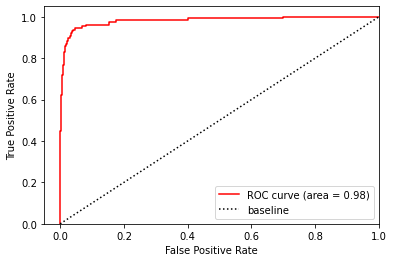

None


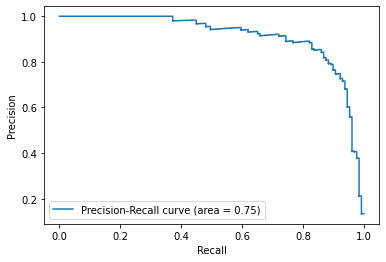

None
True Negatives:  1091
False Positives:  98
False Negatives:  6
True Positives:  123
Total STEMI:  129
None


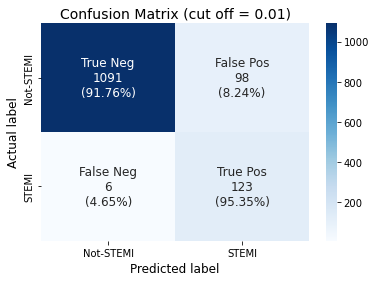

In [83]:
de_pred = (de_proba > dval_yi).astype(np.int64)
result_report(y_test, de_pred, de_proba, sval_yi)

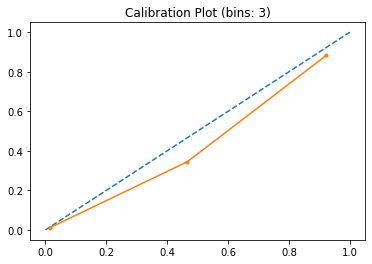

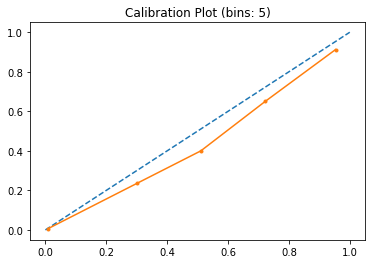

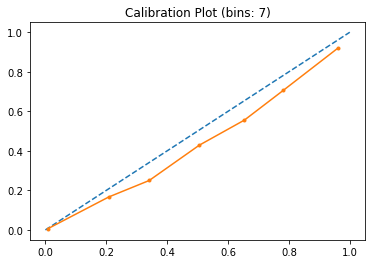

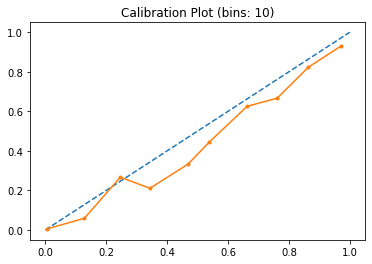

In [85]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, de_proba, i)

# 6. Uncertainty (Entropy) Estimation

### 1) Validation

In [178]:
# Deep Ensembles
de_entropy_list = []
for i in range(len(dval_proba)):
    pq = dval_proba[i] * y_val[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    de_entropy_list.append(entropy)

In [179]:
# Single 
sing_entropy_list = []
for i in range(len(sval_proba)):
    pq = sval_proba[i] * y_val[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    sing_entropy_list.append(entropy)

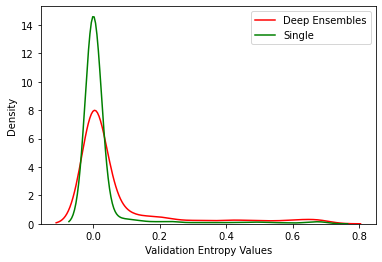

In [138]:
# plot distribution
sns.kdeplot(de_entropy_list, label='Deep Ensembles', color='r')
sns.kdeplot(sing_entropy_list, label='Single', color='g')
plt.xlabel('Validation Entropy Values')
plt.legend()
plt.show()

In [97]:
def uc_grouping(entropy_list, cutoff):
    high_idx = []
    low_idx = []
    for idx, entropy in enumerate(entropy_list):
        if entropy >= cutoff:
            high_idx.append(idx)
        else:
            low_idx.append(idx)
            
    return high_idx, low_idx

In [92]:
print('high 5%: {}'.format(round(len(y_val)*0.05),2))
print('high 10%: {}'.format(round(len(y_val)*0.1),2))
print('high 15%: {}'.format(round(len(y_val)*0.15),2))
print('high 20%: {}'.format(round(len(y_val)*0.2),2))

high 5%: 87
high 10%: 174
high 15%: 261
high 20%: 348


In [142]:
def get_co(list_a, y_true, percent):
    '''
    list_a: [int, int, ...] 
    num: int, 추출하고 싶은 개수 
    '''
    tmp = list_a.copy()
    tmp.sort()
    num = round(len(y_true)* percent*0.01)
    top_num = tmp[-num:]
    cutoff = round(min(top_num),4)
    
    return cutoff

In [ ]:
# deep ensemble

In [180]:
co_05 = get_co(de_entropy_list, y_val, 5)
co_10 = get_co(de_entropy_list, y_val, 10)
co_15 = get_co(de_entropy_list, y_val, 15)
co_20 = get_co(de_entropy_list, y_val, 20)

print(co_05, co_10, co_15, co_20)

0.5364 0.3193 0.1788 0.091


In [181]:
sco_05 = get_co(sing_entropy_list, y_val, 5)
sco_10 = get_co(sing_entropy_list, y_val, 10)
sco_15 = get_co(sing_entropy_list, y_val, 15)
sco_20 = get_co(sing_entropy_list, y_val, 20)

print(sco_05, sco_10, sco_15, sco_20)

0.2167 0.0405 0.0063 0.0008


In [147]:
def compare_uncertainty(entropy_list, y_true, y_proba, y_pred, cutoff):
    high, low = uc_grouping(entropy_list, cutoff=cutoff)
    
    true_high = y_true[high]
    pred_high = y_pred[high]
    proba_high = y_proba[high]

    true_low = y_true[low]
    pred_low = y_pred[low]
    proba_low = y_proba[low]
    
    print("Uncertainty High: %.2f%%" % (len(high) / len(entropy_list) * 100.0)), print(matrix(true_high, pred_high, proba_high))
    print("Uncertainty Low: %.2f%%" % (len(low) / len(entropy_list) * 100.0)), print(matrix(true_low, pred_low, proba_low))

In [150]:
def high_uncertainty(entropy_list, y_true, y_proba, y_pred, cutoff, threshold):
    high, low = uc_grouping(entropy_list, cutoff=cutoff)
    true_high = y_true[high]
    pred_high = y_pred[high]
    proba_high = y_proba[high]
    print("Uncertainty High: %.2f%%" % (len(high) / len(entropy_list) * 100.0)), print(result_report(true_high, pred_high, proba_high, threshold))

def low_uncertainty(entropy_list, y_true, y_proba, y_pred, cutoff, threshold):
    high, low = uc_grouping(entropy_list, cutoff=cutoff)
    true_low = y_true[low]
    pred_low = y_pred[low]
    proba_low = y_proba[low]
    print("Uncertainty Low: %.2f%%" % (len(low) / len(entropy_list) * 100.0)), print(result_report(true_low, pred_low, proba_low, threshold))

Uncertainty High: 19.97%
[[202  24]
 [ 28  93]] 

Accuracy 0.8501
Sensitivity 0.7686
Specificity 0.8938
PPV 0.7949
NPV 0.8783
AUROC 0.8883
Average Precision 0.7722
Precision 0.7949
Recall 0.7686
F1 0.7815


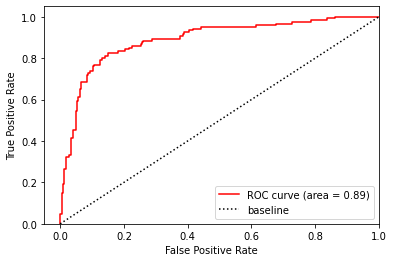

None


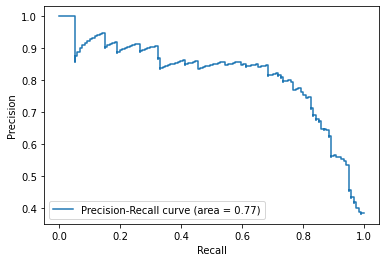

None
None
None


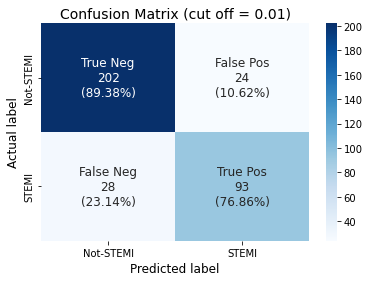

In [169]:
high_uncertainty(sing_entropy_list, y_val, sval_proba, sval_pred, sco_20, sval_yi)

Uncertainty Low: 80.03%
[[1354    1]
 [   6   30]] 

Accuracy 0.995
Sensitivity 0.8333
Specificity 0.9993
PPV 0.9677
NPV 0.9956
AUROC 0.9423
Average Precision 0.9032
Precision 0.9677
Recall 0.8333
F1 0.8955


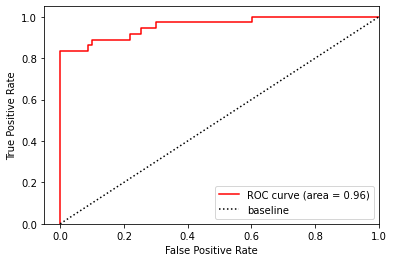

None


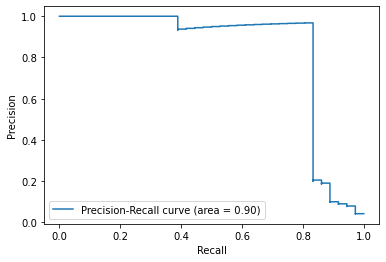

None
None
None


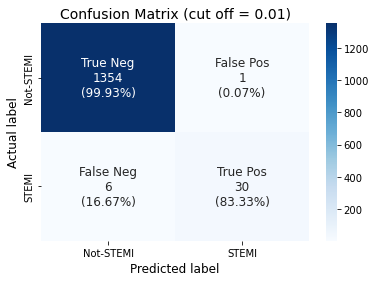

In [171]:
low_uncertainty(sing_entropy_list, y_val, sval_proba, sval_pred, sco_20, sval_yi)

### 2) Test

In [182]:
# Deep Ensembles
de_entropy_list = []
for i in range(len(de_proba)):
    pq = de_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    de_entropy_list.append(entropy)

In [183]:
# Single 
sing_entropy_list = []
for i in range(len(sing_proba)):
    pq = sing_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    sing_entropy_list.append(entropy)

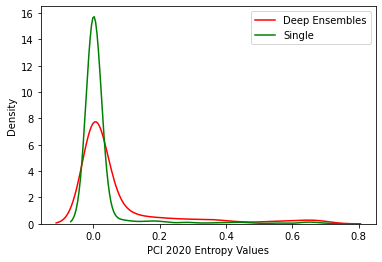

In [184]:
# plot distribution
sns.kdeplot(de_entropy_list, label='Deep Ensembles', color='r')
sns.kdeplot(sing_entropy_list, label='Single', color='g')
plt.xlabel('PCI 2020 Entropy Values')
plt.legend()
plt.show()

## 5.3. Divide Groups and Check Each Group's Results
Uncertainty cutoff 0.0018 (internal test - deep ensemble's entropy의 median)

### 5.3.1. Deep Ensembles

Uncertainty High: 14.87%
[[37 96]
 [ 1 62]] 

Accuracy 0.5051
Sensitivity 0.9841
Specificity 0.2782
PPV 0.3924
NPV 0.9737
AUROC 0.8966
Average Precision 0.5572
Precision 0.8667
Recall 0.2063
F1 0.3333


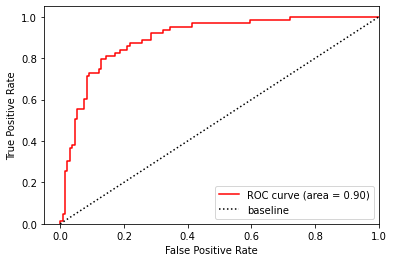

None


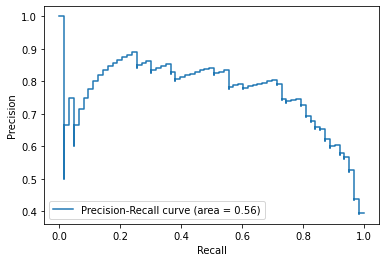

None
None
None


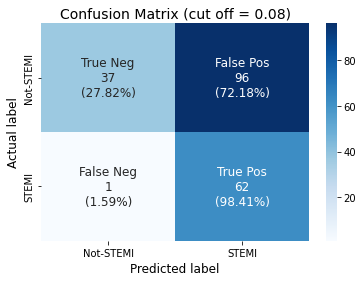

In [186]:
high_uncertainty(de_entropy_list, y_test, de_proba, de_pred, co_15, dval_yi)

Uncertainty Low: 85.13%
[[1054    2]
 [   5   61]] 

Accuracy 0.9938
Sensitivity 0.9242
Specificity 0.9981
PPV 0.9683
NPV 0.9953
AUROC 0.9823
Average Precision 0.9473
Precision 0.9683
Recall 0.9242
F1 0.9457


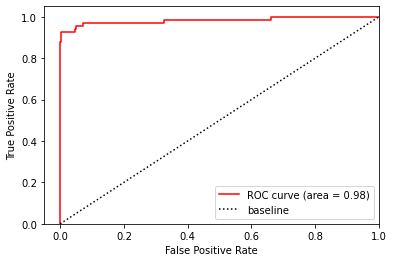

None


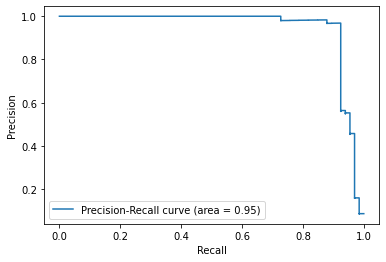

None
None
None


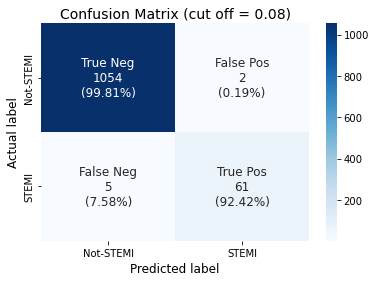

In [187]:
low_uncertainty(de_entropy_list, y_test, de_proba, de_pred, co_15, dval_yi)

#### 5.3.1.2. Single Net

Uncertainty High: 13.35%
[[46 74]
 [ 2 54]] 

Accuracy 0.5682
Sensitivity 0.9643
Specificity 0.3833
PPV 0.4219
NPV 0.9583
AUROC 0.8427
Average Precision 0.6051
Precision 0.7778
Recall 0.5
F1 0.6087


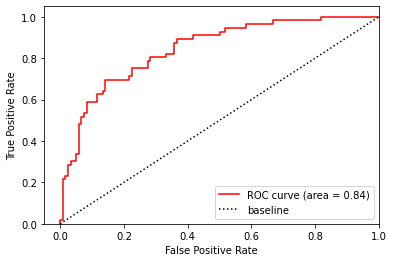

None


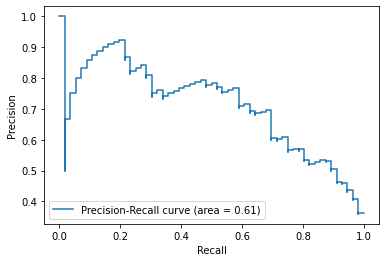

None
None
None


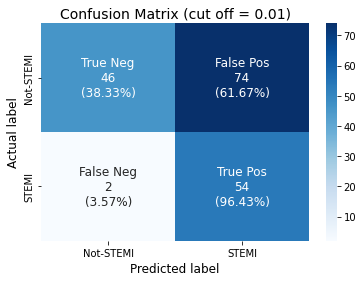

In [188]:
high_uncertainty(sing_entropy_list, y_test, sing_proba, sing_pred, sco_15, sval_yi)

Uncertainty Low: 86.65%
[[1067    2]
 [   5   68]] 

Accuracy 0.9939
Sensitivity 0.9315
Specificity 0.9981
PPV 0.9714
NPV 0.9953
AUROC 0.9843
Average Precision 0.9522
Precision 0.9714
Recall 0.9315
F1 0.951


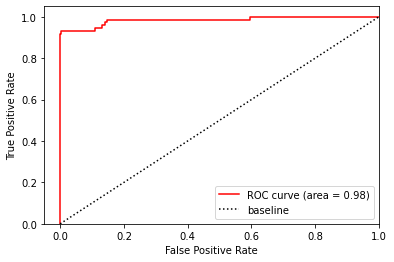

None


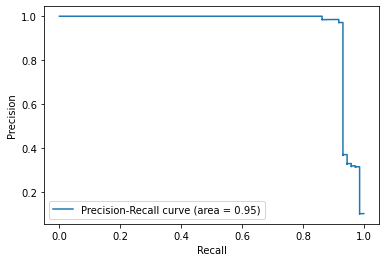

None
None
None


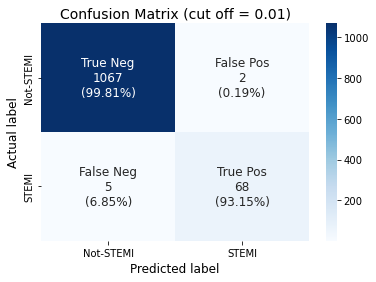

In [189]:
low_uncertainty(sing_entropy_list, y_test, sing_proba, sing_pred, sco_15, sval_yi)